## Adaptive subtraction

In this notebook we apply adaptive subtraction to correct an initial estimate of the multiples in seismic data. Adaptive may be described by the inverse problem

$$
    x_{\star} = arg\min_x \Vert Mx - d\Vert_p + \lambda\Vert x\Vert_q,
$$

where $M$ denotes convolution with an initial estimate of the multiples, $d$ is the total data including primaries and multiples, $x_{\star}$ is the estimated multiples after adaptive subtraction and $\Vert\cdot\Vert_p$ denotes a norm. Guitton et al. have shown that the $L_1$-norm $\Vert\cdot\Vert_1$ on the data is more appropriate than the standard $L_2$-norm $\Vert\cdot\Vert_2^2$-norm for adaptive subtraction. One drawback is that minimizing the $L_1$-norm is non-trivial due to the non-smoothness of the $L_1$-norm, leaving standard gradient-based optimization methods useless. A common approach is to use the Iterative Reweighted Least-Squares (IRLS) algorithm, that solves

$$
    x_{k+1} = arg\min_x \frac{1}{2}\Vert W_k(Mx - d)\Vert_2^2 + \Vert V_kx\Vert_2^2,
$$

where $W_k = \text{diag}\left(\frac{1}{\vert Mx_k - d\vert}\right)$, $V_k = \text{diag}\left(\frac{1}{\vert x_k\vert}\right)$. In this notebook we propose a modified version of the Alternating Direction Method of Multipliers (ADMM), that solves the $L_1$-$L_1$ regularized problem via the following iterations:

\begin{eqnarray*}
x_{k+1} & = & \text{FISTA}\left(M, d + y_k - z_k, \frac{\lambda}{\rho}, x_0=x_k, \text{niter=niter}\right) \\
y_{k+1} & = & \text{soft_thresh}_{1/\rho}\left(Mx_{k+1} - d + z_k\right) \\
z_{k+1} & = & z_k + Mx_{k+1} - y_{k+1} - d
\end{eqnarray*}


First, we load the necessasry libraries

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops

from pylops.optimization.solver import lsqr
from ADMM import ADMM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example from Guitton et al.

First we create the data and the multiples from the paper.

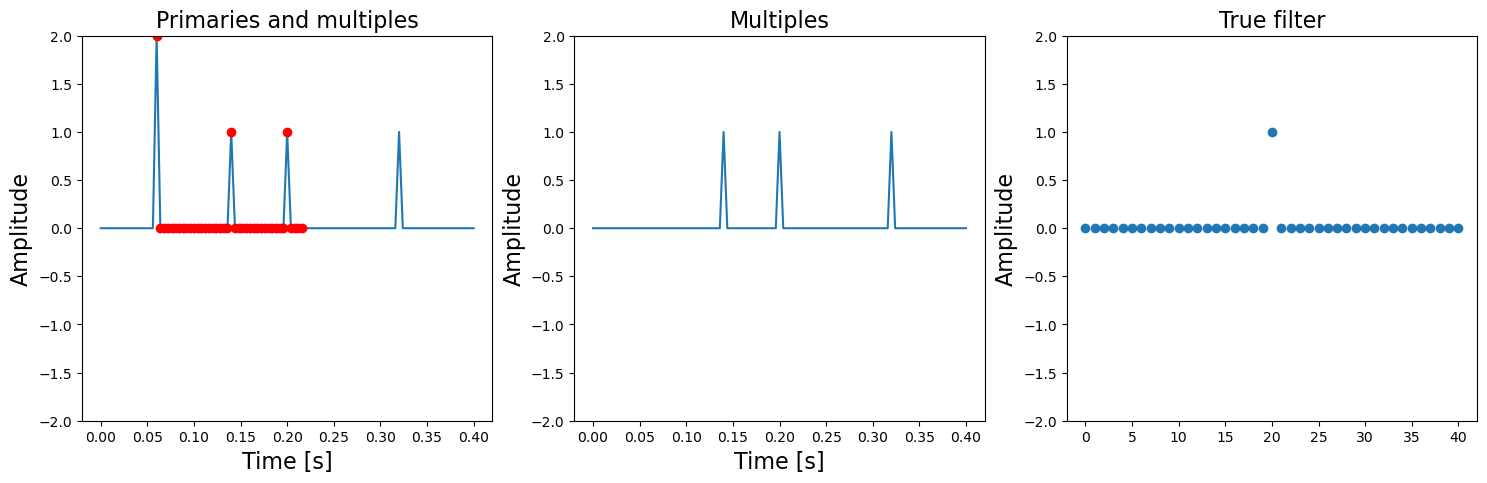

In [2]:
nt = 101
nfilt = 41
t = np.linspace(0, 0.4, nt)
data = np.zeros(nt)
data[np.argwhere(t == 0.06)] = 2
data[np.argwhere(t == 0.14)] = 1
data[np.argwhere(t == 0.20)] = 1
data[np.argwhere(t == 0.32)] = 1
multiples = data.copy()
multiples[np.argwhere(t == 0.06)] = 0
idx = np.argwhere(t == 0.14)[0][0]
mark = [i for i in range(idx-nfilt//2, idx+nfilt//2)]
filt_true = np.zeros(nfilt)
filt_true[nfilt//2] = 1
# plt.plot(vals,poly,markevery=mark, ls="", marker="o", label="points")

# plot the data and the multiples
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(t, data, markevery=mark, marker="o", label="points", markerfacecolor='r', markeredgecolor='r')
# axs[0].plot(t, data, '')
axs[0].set_ylim(-2,2);
axs[0].set_ylabel('Amplitude', fontsize=16)
axs[0].set_xlabel('Time [s]', fontsize=16);
axs[0].set_title('Primaries and multiples', fontsize=16)
axs[1].plot(t, multiples)
axs[1].set_ylim(-2,2);
axs[1].set_ylabel('Amplitude', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=16);
axs[1].set_title('Multiples', fontsize=16);
axs[2].plot(filt_true, 'o')
axs[2].set_ylim(-2,2);
axs[2].set_ylabel('Amplitude', fontsize=16)
axs[2].set_title('True filter', fontsize=16);

Now we make the convolutional operator

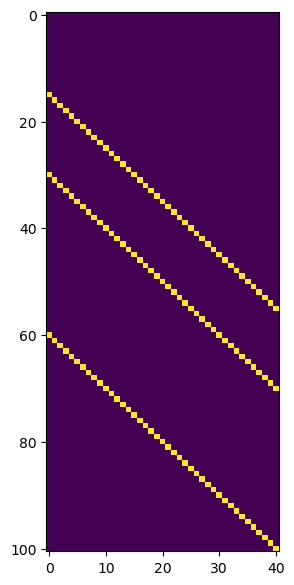

In [9]:
C = pylops.utils.signalprocessing.convmtx(multiples, nfilt)
C = C[nfilt//2:-(nfilt//2)]
Cop = pylops.basicoperators.MatrixMult(C)

fig, axs = plt.subplots(1, 1, figsize=(3,7))
axs.imshow(C, aspect='auto');

Now we try to reconstruct the primaries and multiples via adaptive subtraction using the $L_2$-norm. For this simple example, $\lambda = 0$ so there is no regularization.

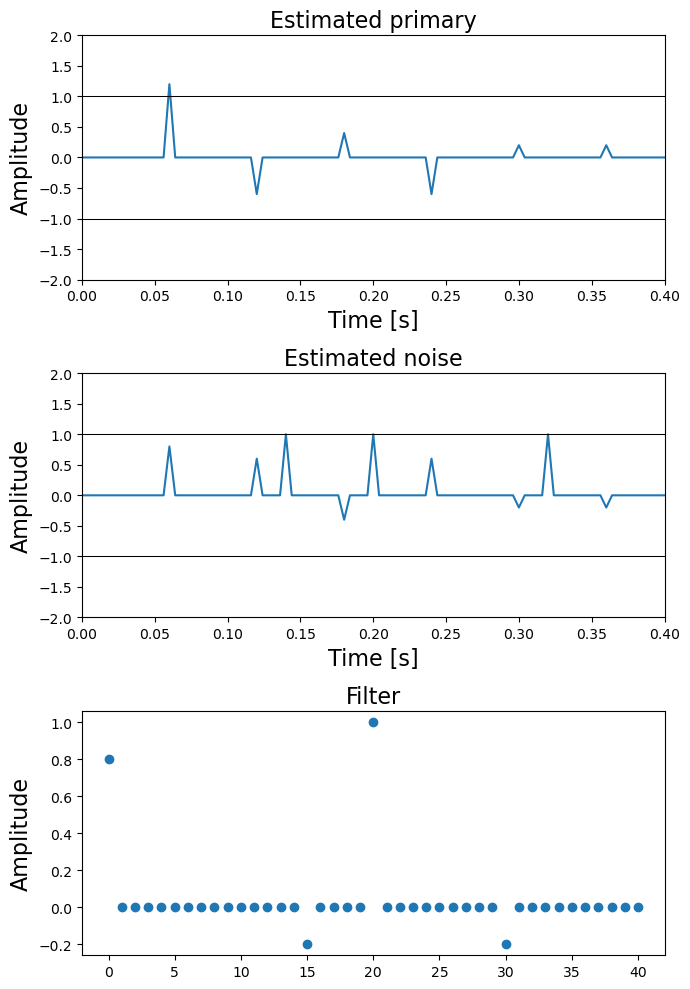

In [8]:
filt = lsqr(Cop, data, x0=np.zeros(nfilt), niter=25)[0]
multiple_est = np.dot(C, filt)
primary_est = data - multiple_est

# plot the estimated primary and the estimated multiples after adaptive subtraction
fig, axs = plt.subplots(3, 1, figsize=(7, 10))
axs[0].plot(t, primary_est)
axs[0].set_ylim(-2,2);
axs[0].set_ylabel('Amplitude', fontsize=16)
axs[0].set_xlabel('Time [s]', fontsize=16);
axs[0].set_title('Estimated primary', fontsize=16)
axs[0].set_xlim(0, 0.4)
axs[0].axhline(y=1, color='k', linewidth=0.75)
axs[0].axhline(y=-1, color='k', linewidth=0.75)
axs[1].plot(t, multiple_est)
axs[1].axhline(y=1, color='k', linewidth=0.75)
axs[1].axhline(y=-1, color='k', linewidth=0.75)
axs[1].set_ylim(-2,2);
axs[1].set_ylabel('Amplitude', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=16);
axs[1].set_title('Estimated noise', fontsize=16);
axs[1].set_xlim(0, 0.4);
axs[2].plot(filt,'o')
axs[2].set_ylabel('Amplitude', fontsize=16)
axs[2].set_title('Filter', fontsize=16);
plt.tight_layout()

Since the $L_2$-norm mimimizes the energy, the data misfit is as low as possible. However, Guitton et al. argue that for adaptive subtraction this is the wrong criterion. Instead, the $L_1$-norm is more appropriate, which we will now use to get the correct primaries and multiples.

In [10]:
filt_l1 = ADMM(Cop, data.ravel(), rho=1e0, nouter=100, ninner=10, eps=0e0)

Error is 0.00000
Residual is 2.00000


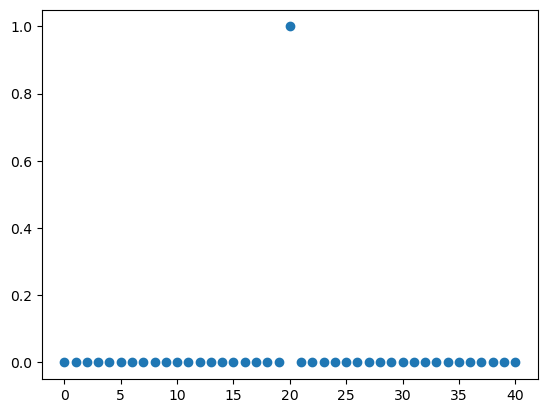

In [11]:
plt.plot(filt_l1,'o');
multiple_l1 = Cop * filt_l1
primary_l1 = data - multiple_l1
error = np.linalg.norm(filt_l1 - filt_true) / np.linalg.norm(filt_true)
residual = np.linalg.norm(multiple_l1 - data, 1)
print(f'Error is {error:.5f}')
print(f'Residual is {residual:.5f}')

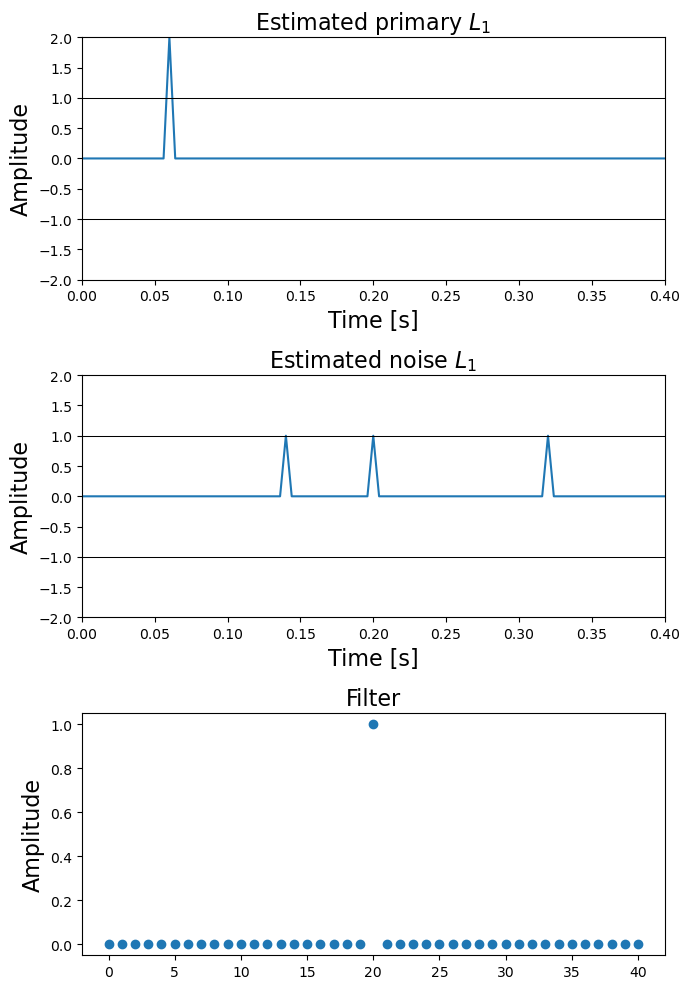

In [12]:
# plot the estimated primary and the estimated multiples after adaptive subtraction
fig, axs = plt.subplots(3, 1, figsize=(7, 10))
axs[0].plot(t, primary_l1)
axs[0].set_ylim(-2,2);
axs[0].set_ylabel('Amplitude', fontsize=16)
axs[0].set_xlabel('Time [s]', fontsize=16);
axs[0].set_title('Estimated primary $L_1$', fontsize=16)
axs[0].set_xlim(0, 0.4)
axs[0].axhline(y=1, color='k', linewidth=0.75)
axs[0].axhline(y=-1, color='k', linewidth=0.75)
axs[1].plot(t, multiple_l1)
axs[1].axhline(y=1, color='k', linewidth=0.75)
axs[1].axhline(y=-1, color='k', linewidth=0.75)
axs[1].set_ylim(-2,2);
axs[1].set_ylabel('Amplitude', fontsize=16)
axs[1].set_xlabel('Time [s]', fontsize=16);
axs[1].set_title('Estimated noise $L_1$', fontsize=16);
axs[1].set_xlim(0, 0.4);
axs[2].plot(filt_l1,'o')
axs[2].set_ylabel('Amplitude', fontsize=16)
axs[2].set_title('Filter', fontsize=16);
plt.tight_layout()

Let's compare the energy for the $L_2$-norm and the $L_1$-norm:

In [13]:
print(f'Energy for L_2-norm solution: {np.linalg.norm(data - multiple_est)**2:.2f}')
print(f'Energy for L_1-norm solution: {np.linalg.norm(multiple_l1 - data)**2:.2f}')

Energy for L_2-norm solution: 2.40
Energy for L_1-norm solution: 4.00


From this example we see that the $L_1$-norm is a more appropriate norm when there is a strong primary dominating the energy. Even though the energy for the $L_1$-norm solution is higher, the reconstructed primaries and multiples are correct. 

This example is quite simple because it is 1D. More importantly, the example is simple because the estimated multiples and the multiples in the total data are the same. Generally, the estimated multiples are not aligned with the multiples in the total data, and that is why adaptive subtraction is needed. 